# Regression Script
## Random Forest

### Florian Beyer
### 2020-04-27
### V0.2

Quellen: 
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://heartbeat.fritz.ai/random-forest-regression-in-python-using-scikit-learn-9e9b147e2153

In [1]:
# Requried Packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets
from joblib import dump, load
from operator import itemgetter

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [2]:
# data input

# define a number of trees that should be used (default = 500)
est = 1000

# Size of splitting the data (0.1 -> 10 % test data, 90 % training data)
testSize = 0.25

randomState = 35

# the remote sensing image you want to classify
img_RS = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\GIS\\Raster\\Multisensor_stack\\B1W_Stack_tif.tif'

# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\SPAD\\2020_05_06_Bliesekow_EP1_SPAD_W.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'SPAD'


# save path, predicted image
prediction_map = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\GIS\\Ergebnis\\B1W_SPAD_RFR.tif'


# save path, trained model
save_model = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\GIS\\Ergebnis\\B1W_SPAD_RFR_model.joblib'


In [3]:
# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

Available attributes in the shape file are: ['Datum_Uhrz', 'Ortho_Heig', 'Local_Elli', 'SPAD', 'B1WCode']


In [4]:
# Data preparation

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [5]:
# Data preparation
# load training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()


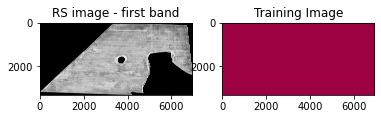

In [6]:
# Display image and Training data

plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()


In [7]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))# Subset the image dataset with the training image = X

We have 50 training samples


In [8]:
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

In [9]:
features = pd.DataFrame(X)

band_names = []
for i in range(X.shape[1]):
#for i in range(0,2500):
    nband = "Band_"+ str(i+1)
    band_names.append(nband)

features.columns = band_names

print('The shape of our features is:', features.shape)
print('The number of Spectra is:', features.shape[0])
print('The number of bands is:', features.shape[1])

features['value'] = y

features.head()


The shape of our features is: (50, 24)
The number of Spectra is: 50
The number of bands is: 24


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_16,Band_17,Band_18,Band_19,Band_20,Band_21,Band_22,Band_23,Band_24,value
0,93.0,110.0,62.0,0.061393,0.030123,0.223525,0.371749,83.198013,0.713376,31.781384,...,-1.039946,0.194021,0.594812,0.277508,-0.030896,0.249001,0.850086,-0.040554,-0.141645,43
1,65.0,83.0,32.0,0.062779,0.029833,0.235297,0.389327,84.212082,0.748821,29.997913,...,-1.086714,0.202041,0.621157,0.289761,-0.032183,0.246596,0.857652,-0.041749,-0.200004,43
2,59.0,82.0,31.0,0.064433,0.029586,0.234566,0.410683,82.499832,0.791779,27.410128,...,-1.173597,0.219361,0.651551,0.295002,-0.036927,0.272943,0.865601,-0.044273,-0.194383,42
3,46.0,64.0,16.0,0.062620,0.028081,0.238777,0.412774,82.707291,0.797466,28.541834,...,-1.173541,0.218155,0.660245,0.296587,-0.037053,0.267051,0.872606,-0.043053,-0.266641,42
4,142.0,129.0,83.0,0.081423,0.068457,0.200887,0.302140,83.896965,0.535823,24.173132,...,-0.806786,0.159008,0.382543,0.277124,-0.024612,0.201287,0.630559,-0.041020,0.186949,27


In [10]:
# Labels are the values we want to predict
labels = np.array(features['value'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('value', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = testSize, random_state = randomState)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (37, 24)
Training Labels Shape: (37,)
Testing Features Shape: (13, 24)
Testing Labels Shape: (13,)


In [11]:
RFR = RandomForestRegressor(bootstrap=True,
                             criterion='mse',
                             max_depth=None,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             min_weight_fraction_leaf=0.0,
                             n_estimators=est,
                             n_jobs=-1, # using all cores
                             oob_score=True,
                             random_state=randomState,
                             verbose=1,
                             warm_start=False)

RFR.fit(train_features, train_labels);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.7s finished


In [12]:
RFR.oob_score_

0.6740436197053176

In [13]:
RFR.score(train_features, train_labels)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.9561231981895789

In [14]:
# band importances
imp = {}
for i in range(len(RFR.feature_importances_)):
    importance = round(RFR.feature_importances_[i]*100,2)
    print('Band {}: {}'.format(i+1, importance))
    imp['Band{}'.format(i+1)] = importance

Band 1: 11.9
Band 2: 1.1
Band 3: 3.42
Band 4: 19.55
Band 5: 7.61
Band 6: 1.2
Band 7: 1.72
Band 8: 1.2
Band 9: 1.69
Band 10: 4.06
Band 11: 0.81
Band 12: 6.12
Band 13: 1.86
Band 14: 2.09
Band 15: 2.62
Band 16: 1.48
Band 17: 3.35
Band 18: 2.79
Band 19: 1.64
Band 20: 5.9
Band 21: 7.12
Band 22: 5.02
Band 23: 1.18
Band 24: 4.56


In [15]:
sorted_imp = dict(sorted(imp.items(), key=itemgetter(1), reverse=True))
sorted_imp 

{'Band4': 19.55,
 'Band1': 11.9,
 'Band5': 7.61,
 'Band21': 7.12,
 'Band12': 6.12,
 'Band20': 5.9,
 'Band22': 5.02,
 'Band24': 4.56,
 'Band10': 4.06,
 'Band3': 3.42,
 'Band17': 3.35,
 'Band18': 2.79,
 'Band15': 2.62,
 'Band14': 2.09,
 'Band13': 1.86,
 'Band7': 1.72,
 'Band9': 1.69,
 'Band19': 1.64,
 'Band16': 1.48,
 'Band6': 1.2,
 'Band8': 1.2,
 'Band23': 1.18,
 'Band2': 1.1,
 'Band11': 0.81}

In [16]:
# Use the forest's predict method on the test data
predictions_test_ds = RFR.predict(test_features)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [17]:
# Calculate the absolute errors
errors = abs(predictions_test_ds - test_labels)
# Print out the mean absolute error (mae)

# Print out the mean absolute error (mae)


print('-------------')
print('n of the test data: {}'.format(len(test_labels)))
print('Mean of the variable: {:.2f}'.format(np.mean(labels)))
print('Standard deviation of the variable: {:.2f}'.format(np.std(labels)))
print('-------------')
print('Mean Absolute Error: {:.2f}'.format(np.mean(errors)))

mse = mean_squared_error(test_labels, predictions_test_ds)
print('Mean squared error: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(np.sqrt(mse)))

'''
To put our predictions in perspective, we can calculate an accuracy using
the mean average percentage error subtracted from 100 %.
'''

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('mean absolute percentage error (MAPE) / Accuracy: {:.2f}'.format(accuracy), '%.')
print('-------------')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination r²: {:.2f}'.format(r2_score(test_labels, predictions_test_ds)))



-------------
n of the test data: 13
Mean of the variable: 39.44
Standard deviation of the variable: 6.67
-------------
Mean Absolute Error: 2.91
Mean squared error: 15.06
RMSE: 3.88
mean absolute percentage error (MAPE) / Accuracy: 92.78 %.
-------------
Coefficient of determination r²: 0.73


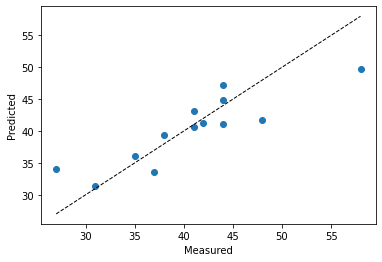

In [18]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions_test_ds)
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

In [19]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (3293, 6932, 24) to (22827076, 24)


In [20]:
prediction_ = RFR.predict(img_as_array)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  2.9min finished


In [21]:
prediction = prediction_.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(prediction.shape))

Reshaped back to (3293, 6932)


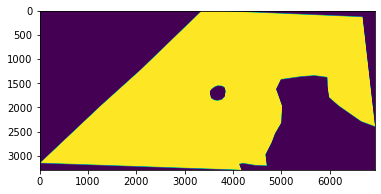

In [22]:
# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 1.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

In [23]:
# mask classification an plot

prediction.astype(np.float32)
prediction = prediction*mask



In [24]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

prediction.astype(np.float32)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(prediction_map, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(prediction)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(prediction_map))

Image saved to: N:\Daten_GG\projekte\PFIFFikus (EFRE) - 74120125\Bilder\2020_06_05_Bliesekow_EP1\GIS\Ergebnis\B1W_SPAD_RFR.tif


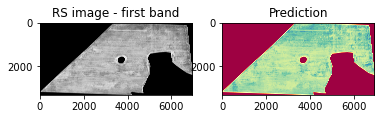

In [25]:
# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(prediction, cmap=plt.cm.Spectral)
plt.title('Prediction')

plt.show()

predicted 31.07 vs. 32.0 observed
predicted 47.03 vs. 48.0 observed
predicted 30.9 vs. 29.0 observed
predicted 30.0 vs. 30.0 observed
predicted 43.89 vs. 42.0 observed
predicted 45.84 vs. 54.0 observed
predicted 40.96 vs. 32.0 observed
predicted 42.0 vs. 42.0 observed
predicted 42.84 vs. 43.0 observed
predicted 38.96 vs. 39.0 observed
predicted 39.68 vs. 37.0 observed
predicted 34.04 vs. 29.0 observed
predicted 39.51 vs. 43.0 observed
predicted 44.46 vs. 43.0 observed
predicted 36.17 vs. 29.0 observed
predicted 42.82 vs. 47.0 observed
predicted 38.41 vs. 32.0 observed
predicted 33.81 vs. 36.0 observed
predicted 37.83 vs. 44.0 observed
predicted 31.78 vs. 31.0 observed
predicted 37.96 vs. 41.0 observed
predicted 43.2 vs. 42.0 observed
predicted 43.41 vs. 45.0 observed
predicted 42.46 vs. 40.0 observed
predicted 37.35 vs. 41.0 observed
predicted 43.7 vs. 45.0 observed
predicted 44.29 vs. 43.0 observed
predicted 46.48 vs. 46.0 observed
predicted 31.97 vs. 30.0 observed
predicted 46.31 vs.

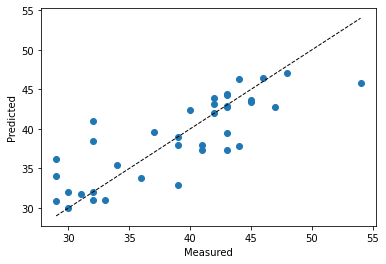

In [26]:
pred1 = np.array(RFR.oob_prediction_)
obs = np.array(train_labels)
obs = [np.float(i) for i in obs]

for i in range(len(pred1)):
    print('predicted {} vs. {} observed'.format(round(pred1[i],2), round(obs[i],2)))

#print(pred1)
#print(obs)

fig,ax = plt.subplots()
ax.scatter(obs,pred1)
ax.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [27]:
print('Mean squared error: %.2f'
      % mean_squared_error(obs, pred1))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(obs, pred1))

Mean squared error: 12.94
Coefficient of determination: 0.67
